In [8]:
# Rainfall Prediction using Elastic Net and XGBoost

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import xgboost as xgb


In [9]:

# Load datasets
train_path = "train.csv"  # Update with your file path
test_path = "test.csv"    # Update with your file path

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [10]:
# Inspect dataset
print(df_train.head())
print(df_train.info())

   id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
0   0    1    1017.4     21.2         20.6     19.9      19.4      87.0   
1   1    2    1019.5     16.2         16.9     15.8      15.4      95.0   
2   2    3    1024.1     19.4         16.1     14.6       9.3      75.0   
3   3    4    1013.4     18.1         17.8     16.9      16.8      95.0   
4   4    5    1021.8     21.3         18.4     15.2       9.6      52.0   

   cloud  sunshine  winddirection  windspeed  rainfall  
0   88.0       1.1           60.0       17.2         1  
1   91.0       0.0           50.0       21.9         1  
2   47.0       8.3           70.0       18.1         1  
3   95.0       0.0           60.0       35.6         1  
4   45.0       3.6           40.0       24.8         0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id     

/tmp/ipykernel_40990/1223120737.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rainfall", data=df_train, palette="coolwarm")


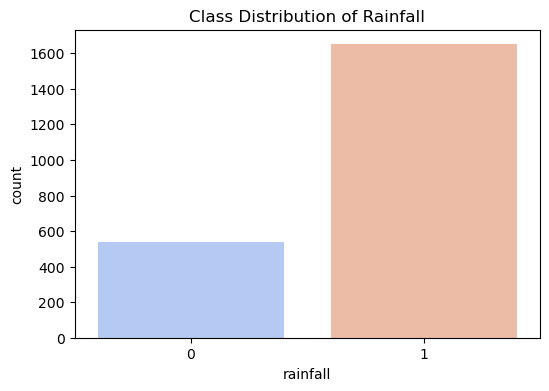

In [11]:
# Check class distribution in the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x="rainfall", data=df_train, palette="coolwarm")
plt.title("Class Distribution of Rainfall")
plt.show()

In [12]:
# Separate features and target
X_train = df_train.drop(columns=["rainfall"])  # Features
y_train = df_train["rainfall"]                 # Target

# Split training data for validation
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)





In [13]:
# Identify categorical and numerical columns
categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()
numerical_features = X_train.select_dtypes(exclude=["object"]).columns.tolist()

In [14]:
# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

In [ ]:
# Feature selection using Logistic Regression with Elastic Net
elastic_net = LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=0.5, max_iter=5000)

feature_selection_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("feature_selection", SelectFromModel(elastic_net))
])

# Perform 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(elastic_net, preprocessor.fit_transform(X_train), y_train, cv=cv, scoring="accuracy")
print(f"10-fold CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Train Elastic Net Model
elastic_net_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", elastic_net)
])

elastic_net_pipeline.fit(X_train, y_train)

# Predict using Elastic Net
y_pred_elastic = elastic_net_pipeline.predict(X_test)

# Model Evaluation - Elastic Net
print("Elastic Net Classification Report:")
print(classification_report(y_test, y_pred_elastic))

In [16]:
# Train XGBoost Model
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic", eval_metric="auc", use_label_encoder=False
)

xgb_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", xgb_clf)
])

xgb_pipeline.fit(X_train_split, y_train_split)

# Predict using XGBoost
y_pred_xgb = xgb_pipeline.predict(X_val)
y_pred_proba_xgb = xgb_pipeline.predict_proba(X_val)[:, 1]

In [18]:
# Model Evaluation - XGBoost
print("XGBoost Classification Report:")
print(classification_report(y_val, y_pred_xgb))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.59      0.68       119
           1       0.86      0.94      0.90       319

    accuracy                           0.85       438
   macro avg       0.83      0.77      0.79       438
weighted avg       0.84      0.85      0.84       438



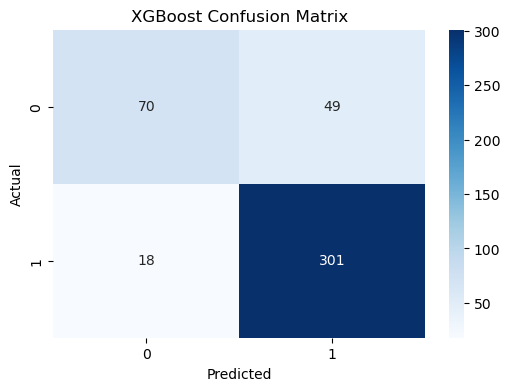

In [19]:
# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_val, y_pred_xgb), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()

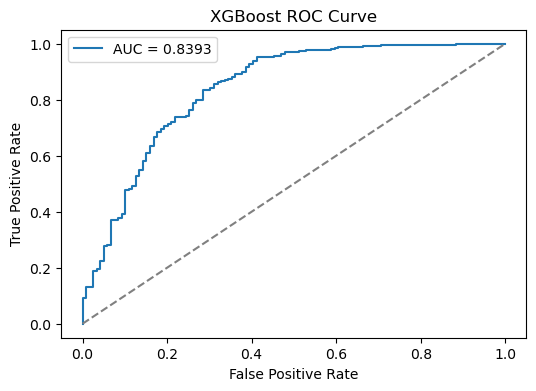

In [22]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred_proba_xgb)
auc_score = roc_auc_score(y_val, y_pred_proba_xgb)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve")
plt.legend()
plt.show()

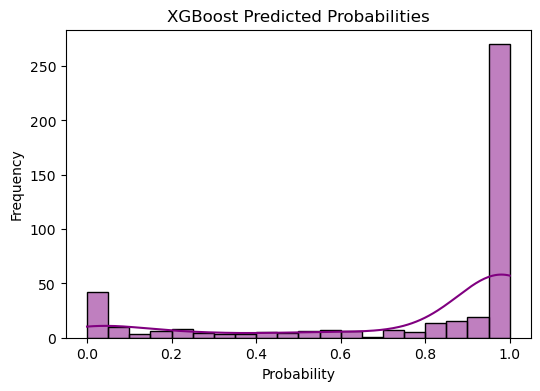

In [23]:
# Probability Plot
plt.figure(figsize=(6, 4))
sns.histplot(y_pred_proba_xgb, kde=True, bins=20, color="purple")
plt.title("XGBoost Predicted Probabilities")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Rainfall Prediction using Elastic Net and XGBoost

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import xgboost as xgb

# Load datasets
train_path = "train.csv"  # Update with your file path
test_path = "test.csv"    # Update with your file path

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Inspect dataset
print(df_train.head())
print(df_train.info())

# Check class distribution in the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x="rainfall", data=df_train, palette="coolwarm")
plt.title("Class Distribution of Rainfall")
plt.show()

# Separate features and target
X_train = df_train.drop(columns=["rainfall"])  # Features
y_train = df_train["rainfall"]                 # Target

X_test = df_test.drop(columns=["rainfall"])    # Features
y_test = df_test["rainfall"]                   # Target

# Identify categorical and numerical columns
categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()
numerical_features = X_train.select_dtypes(exclude=["object"]).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])





# Model Evaluation - XGBoost
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_xgb)
auc_score = roc_auc_score(y_test, y_pred_proba_xgb)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve")
plt.legend()
plt.show()

# Probability Plot
plt.figure(figsize=(6, 4))
sns.histplot(y_pred_proba_xgb, kde=True, bins=20, color="purple")
plt.title("XGBoost Predicted Probabilities")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()